In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import copy
import scipy.integrate as spi
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely import geometry
import gc
import pyproj

plt.rcParams['font.sans-serif']=['SimHei'] 
plt.rcParams['axes.unicode_minus']=False 

In [2]:
df_taxi=pd.read_csv('202003.csv')
df_taxi

,Unnamed: 0,index,202003
0,0,0,0.000020
1,1,1,0.002398
2,2,2,0.002976
3,3,3,0.000287
4,4,4,0.000569
...,...,...,...
255,255,255,0.002752
256,256,256,0.004019
257,257,257,0.002790
258,258,258,0.005272


In [3]:
gdf=gpd.read_file(r'C:\jupyter notebook\PAPER\data for taxi\dbf_file\taxi_zones.shp')
gdf=gdf[(gdf['OBJECTID']!=1) & (gdf['OBJECTID']!=103) & (gdf['OBJECTID']!=104)]
gdf=gdf[['OBJECTID','borough','Shape_Area','geometry']]
gdf=gdf.reset_index(drop=True)
gdf=gdf.reset_index(drop=False)
gdf['LocationID']=gdf['index']
gdf=gdf[['LocationID','borough','Shape_Area','geometry']]
gdf

,LocationID,borough,Shape_Area,geometry
0,0,Queens,0.004866,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
1,1,Bronx,0.000314,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
2,2,Manhattan,0.000112,"POLYGON ((992073.467 203714.076, 992068.667 20..."
3,3,Staten Island,0.000498,"POLYGON ((935843.310 144283.336, 936046.565 14..."
4,4,Staten Island,0.000606,"POLYGON ((966568.747 158679.855, 966615.256 15..."
...,...,...,...,...
255,255,Bronx,0.000395,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
256,256,Queens,0.000422,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
257,257,Manhattan,0.000034,"POLYGON ((980555.204 196138.486, 980570.792 19..."
258,258,Manhattan,0.000122,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


In [4]:
gdf['PI']=df_taxi['202003']
gdf

,LocationID,borough,Shape_Area,geometry,PI
0,0,Queens,0.004866,"MULTIPOLYGON (((1033269.244 172126.008, 103343...",0.000020
1,1,Bronx,0.000314,"POLYGON ((1026308.770 256767.698, 1026495.593 ...",0.002398
2,2,Manhattan,0.000112,"POLYGON ((992073.467 203714.076, 992068.667 20...",0.002976
3,3,Staten Island,0.000498,"POLYGON ((935843.310 144283.336, 936046.565 14...",0.000287
4,4,Staten Island,0.000606,"POLYGON ((966568.747 158679.855, 966615.256 15...",0.000569
...,...,...,...,...,...
255,255,Bronx,0.000395,"POLYGON ((1025414.782 270986.139, 1025138.624 ...",0.002752
256,256,Queens,0.000422,"POLYGON ((1011466.966 216463.005, 1011545.889 ...",0.004019
257,257,Manhattan,0.000034,"POLYGON ((980555.204 196138.486, 980570.792 19...",0.002790
258,258,Manhattan,0.000122,"MULTIPOLYGON (((999804.795 224498.527, 999824....",0.005272


In [5]:
gdf.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - New York - counties of Bronx; Kings; Nassau; New York; Queens; Richmond; Suffolk.
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

# Analysis of the subway data

In [6]:
df=pd.read_csv(r'C:\jupyter notebook\PAPER\subway_nyc_data\MTA_Subway_Hourly_Ridership__Beginning_February_2022.csv')
df

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference
0,10/06/2022 10:00:00 PM,N520,"Grand St (B,D)",M,"B,D",All,1,0.0,40.718266,-73.993750,POINT (-73.99375 40.718266)
1,02/19/2022 01:00:00 AM,H015,Grand St (L),BK,L,All,17,0.0,40.711926,-73.940670,POINT (-73.94067 40.711926)
2,08/26/2022 03:00:00 AM,H015,Grand St (L),BK,L,All,8,0.0,40.711926,-73.940670,POINT (-73.94067 40.711926)
3,03/25/2022 01:00:00 AM,N213,"Tremont Av (B,D)",BX,"B,D",All,12,0.0,40.850410,-73.905230,POINT (-73.90523 40.85041)
4,03/27/2022 02:00:00 AM,N213,"Tremont Av (B,D)",BX,"B,D",All,6,0.0,40.850410,-73.905230,POINT (-73.90523 40.85041)
...,...,...,...,...,...,...,...,...,...,...,...
4710362,06/14/2022 08:00:00 AM,R419,Zerega Av (6),BX,6,All,220,0.0,40.836487,-73.847040,POINT (-73.84704 40.836487)
4710363,07/17/2022 06:00:00 AM,R523,Woodside-61 St (7),Q,7,All,207,6.0,40.745630,-73.902985,POINT (-73.902985 40.74563)
4710364,04/02/2023 09:00:00 PM,N530,York St (F),BK,F,All,336,0.0,40.701397,-73.986750,POINT (-73.98675 40.701397)
4710365,07/15/2022 02:00:00 AM,R419,Zerega Av (6),BX,6,All,2,0.0,40.836487,-73.847040,POINT (-73.84704 40.836487)


In [7]:
df['date']=df['transit_timestamp'].apply(lambda r:int(''.join(r.split(' ')[0].split('/')[::-1])))
df.sort_values(by='date')
df=df[(df['date']>20220300)&(df['date']<20220400)]
df

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,date
9,05/03/2022 10:00:00 PM,H007,1 Av (L),M,L,All,470,1.0,40.730953,-73.981630,POINT (-73.98163 40.730953),20220305
26,02/03/2022 09:00:00 PM,H007,1 Av (L),M,L,All,284,0.0,40.730953,-73.981630,POINT (-73.98163 40.730953),20220302
144,11/03/2022 10:00:00 AM,R170,103 St (1),M,1,All,486,4.0,40.799446,-73.968376,POINT (-73.968376 40.799446),20220311
182,04/03/2022 01:00:00 PM,R252,103 St (6),M,6,All,221,1.0,40.790600,-73.947480,POINT (-73.94748 40.7906),20220304
220,09/03/2022 11:00:00 PM,H007,1 Av (L),M,L,All,549,8.0,40.730953,-73.981630,POINT (-73.98163 40.730953),20220309
...,...,...,...,...,...,...,...,...,...,...,...,...
4710164,09/03/2022 04:00:00 PM,R523,Woodside-61 St (7),Q,7,All,560,18.0,40.745630,-73.902985,POINT (-73.902985 40.74563),20220309
4710279,05/03/2022 10:00:00 AM,N530,York St (F),BK,F,All,238,3.0,40.701397,-73.986750,POINT (-73.98675 40.701397),20220305
4710317,03/03/2022 05:00:00 PM,R419,Zerega Av (6),BX,6,All,93,2.0,40.836487,-73.847040,POINT (-73.84704 40.836487),20220303
4710335,06/03/2022 12:00:00 PM,N530,York St (F),BK,F,All,294,3.0,40.701397,-73.986750,POINT (-73.98675 40.701397),20220306


In [8]:
p1=pyproj.Proj(init='epsg:4326')
p2=pyproj.Proj(init='epsg:2263')
df['longitude'],df['latitude']=pyproj.transform(p1,p2,list(df['longitude']),list(df['latitude']))
df

,transit_timestamp,station_complex_id,station_complex,borough,routes,payment_method,ridership,transfers,latitude,longitude,Georeference,date
9,05/03/2022 10:00:00 PM,H007,1 Av (L),M,L,All,470,1.0,205582.994143,9.893413e+05,POINT (-73.98163 40.730953),20220305
26,02/03/2022 09:00:00 PM,H007,1 Av (L),M,L,All,284,0.0,205582.994143,9.893413e+05,POINT (-73.98163 40.730953),20220302
144,11/03/2022 10:00:00 AM,R170,103 St (1),M,1,All,486,4.0,230538.303915,9.930056e+05,POINT (-73.968376 40.799446),20220311
182,04/03/2022 01:00:00 PM,R252,103 St (6),M,6,All,221,1.0,227318.178581,9.987930e+05,POINT (-73.94748 40.7906),20220304
220,09/03/2022 11:00:00 PM,H007,1 Av (L),M,L,All,549,8.0,205582.994143,9.893413e+05,POINT (-73.98163 40.730953),20220309
...,...,...,...,...,...,...,...,...,...,...,...,...
4710164,09/03/2022 04:00:00 PM,R523,Woodside-61 St (7),Q,7,All,560,18.0,210944.641416,1.011132e+06,POINT (-73.902985 40.74563),20220309
4710279,05/03/2022 10:00:00 AM,N530,York St (F),BK,F,All,238,3.0,194814.585490,9.879239e+05,POINT (-73.98675 40.701397),20220305
4710317,03/03/2022 05:00:00 PM,R419,Zerega Av (6),BX,6,All,93,2.0,244069.048634,1.026576e+06,POINT (-73.84704 40.836487),20220303
4710335,06/03/2022 12:00:00 PM,N530,York St (F),BK,F,All,294,3.0,194814.585490,9.879239e+05,POINT (-73.98675 40.701397),20220306


In [9]:
df=df.groupby(['latitude','longitude']).sum().reset_index()
df['start_num']=df['ridership']+df['transfers']
df=df[['latitude','longitude','start_num']]
df

,latitude,longitude,start_num
0,149175.598302,9.909338e+05,19445.0
1,149244.382487,9.930006e+05,20989.0
2,149647.768321,9.894641e+05,105551.0
3,149721.347851,9.949810e+05,73217.0
4,150956.161419,9.913138e+05,9300.0
...,...,...,...
418,262954.747307,1.031025e+06,24776.0
419,263271.209006,1.012292e+06,49232.0
420,264723.992109,1.023655e+06,27728.0
421,266615.598051,1.024507e+06,19425.0


In [10]:
L=[]
for i in range(len(df)):
    L.append(geometry.Point(df.iloc[i]['longitude'],df.iloc[i]['latitude']))
geometry1=gpd.GeoSeries(L)
geometry1

0       POINT (990933.773 149175.598)
1       POINT (993000.550 149244.382)
2       POINT (989464.130 149647.768)
3       POINT (994981.020 149721.348)
4       POINT (991313.836 150956.161)
                    ...              
418    POINT (1031025.078 262954.747)
419    POINT (1012291.985 263271.209)
420    POINT (1023654.910 264723.992)
421    POINT (1024507.464 266615.598)
422    POINT (1025543.987 268346.510)
Length: 423, dtype: geometry

In [11]:
gdf1=gpd.GeoDataFrame()
gdf1['latitude']=df['latitude']#.T.values.tolist()[0]
gdf1['longitude']=df['longitude']#.T.values.tolist()[0]
gdf1['start_num']=df['start_num']#.T.values.tolist()[0]
gdf1['geometry']=geometry1
gdf1.sort_values(by='start_num')
gdf1=gdf1.reset_index()
gdf1

,index,latitude,longitude,start_num,geometry
0,0,149175.598302,9.909338e+05,19445.0,POINT (990933.773 149175.598)
1,1,149244.382487,9.930006e+05,20989.0,POINT (993000.550 149244.382)
2,2,149647.768321,9.894641e+05,105551.0,POINT (989464.130 149647.768)
3,3,149721.347851,9.949810e+05,73217.0,POINT (994981.020 149721.348)
4,4,150956.161419,9.913138e+05,9300.0,POINT (991313.836 150956.161)
...,...,...,...,...,...
418,418,262954.747307,1.031025e+06,24776.0,POINT (1031025.078 262954.747)
419,419,263271.209006,1.012292e+06,49232.0,POINT (1012291.985 263271.209)
420,420,264723.992109,1.023655e+06,27728.0,POINT (1023654.910 264723.992)
421,421,266615.598051,1.024507e+06,19425.0,POINT (1024507.464 266615.598)


# The relation ship between subway stations and taxi zones

In [12]:
gdf2=gpd.overlay(gdf1,gdf,how='union')
gdf2

,index,latitude,longitude,start_num,LocationID,borough,Shape_Area,PI,geometry
0,0.0,149175.598302,9.909338e+05,19445.0,53,Brooklyn,0.000736,0.002522,POINT (990933.773 149175.598)
1,2.0,149647.768321,9.894641e+05,105551.0,53,Brooklyn,0.000736,0.002522,POINT (989464.130 149647.768)
2,4.0,150956.161419,9.913138e+05,9300.0,53,Brooklyn,0.000736,0.002522,POINT (991313.836 150956.161)
3,1.0,149244.382487,9.930006e+05,20989.0,27,Brooklyn,0.000202,0.002198,POINT (993000.550 149244.382)
4,3.0,149721.347851,9.949810e+05,73217.0,27,Brooklyn,0.000202,0.002198,POINT (994981.020 149721.348)
...,...,...,...,...,...,...,...,...,...
418,415.0,261601.077493,1.011661e+06,26929.0,216,Bronx,0.000313,0.003493,POINT (1011660.704 261601.077)
419,419.0,263271.209006,1.012292e+06,49232.0,216,Bronx,0.000313,0.003493,POINT (1012291.985 263271.209)
420,418.0,262954.747307,1.031025e+06,24776.0,79,Bronx,0.000400,0.002826,POINT (1031025.078 262954.747)
421,421.0,266615.598051,1.024507e+06,19425.0,255,Bronx,0.000395,0.002752,POINT (1024507.464 266615.598)


In [13]:
df2=gdf2[['start_num','borough']]
df2=df2.groupby('borough').sum()
df2

,start_num
borough,
Bronx,2562052.0
Brooklyn,7223789.0
Manhattan,16377578.0
Queens,5017700.0


In [14]:
df3=gdf[['borough','PI']]
df3=df3.groupby('borough').sum()
df3

,PI
borough,
Bronx,0.147508
Brooklyn,0.251635
Manhattan,0.405161
Queens,0.179495
Staten Island,0.016201


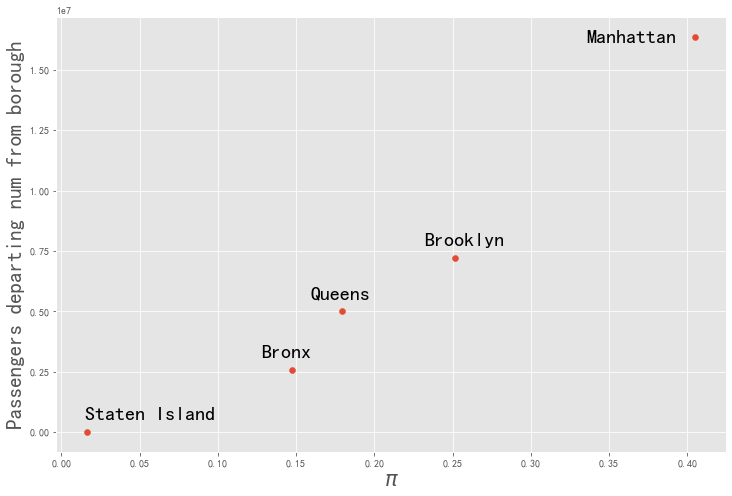

In [16]:
PI=[0.147508,0.251635,0.405161,0.179495,0.016201]
PASSENGER_NUM=[2562052.0,7223789.0,16377578.0,5017700.0,0]
direction_x=[0.02,0.02,0.07,0.02,0.001]
direction_y=[500000,500000,-250000,500000,500000]
NAME=['Bronx','Brooklyn','Manhattan','Queens','Staten Island']
plt.subplots(figsize=(12,8))
plt.style.use('ggplot')
plt.scatter(PI,PASSENGER_NUM)
for i, name in enumerate(NAME):
    plt.text(PI[i]-direction_x[i],PASSENGER_NUM[i]+direction_y[i], name, color='black', fontsize=20)
plt.xlabel('$\pi$',fontsize=21)
plt.ylabel('Passengers departing num from borough',fontsize=21)
plt.savefig(r' The relationship between pi and subway departure passengers.svg',dpi=1000,format='svg')